Hand written data

In [1]:
import pandas as pd 

# Data to be used for the DataFrame
data = {
    'ipv4': ['56.73.174.168', '56.73.174.168', '56.73.174.168', '33.73.174.111', '33.73.174.111', '33.73.174.111'],
    #'ipv4': ['1', '2', '3', '4', '5', '6'],
    'scan_id': [0, 1, 2, 3, 4, 5],
    'port': [[161, 22, 25, 111, 110],[161, 33, 22, 25, 110],[161, 22, 25, 110], [22, 110, 33, 25],[22, 110, 45, 25],[22, 110, 25]],
    'service': [['SNMP', 'SSH', 'SMTP', 'POP3', 'HTTP'],['POP3', 'SNMP', 'SSH', 'HTTP', 'SMTP'],['SNMP', 'SMTP', 'HTTP' 'POP3'], ['SSH', 'HSS', 'POP3', 'SMTP'],['SSH', 'POP3', 'X', 'SMTP'],['SSH', 'POP3', 'SMTP']]
}

#df = pd.DataFrame(data)
#print(df)


In [2]:
from importlib import reload
import generate_data_functions
reload(generate_data_functions)
from generate_data_functions import *

from importlib import reload
import grouped_iForest_functions
reload(grouped_iForest_functions)
from grouped_iForest_functions import *

from sklearn.ensemble import IsolationForest
from statistics import mean
import matplotlib.pyplot as plt

In [9]:
def summarization(df, threshold=0):        
    # Summarize the data by grouping by IP address and counting port and service occurrences
    df_sum = summarize_features(df)
    #print(df.columns)
    '''print(df_sum.columns)
    print('df_sum',df_sum)'''

    '''S = set(df_sum[df_sum['anomaly'] == 1]['ip_id'].unique())
    df_filtered = df_sum[df_sum['ip_id'].isin(S)]
    #print(df_filtered.drop(columns = ['ip_id']))'''

    df_sum = df_sum.rename(str,axis="columns")
    df_sum.to_csv("output.csv", index=False)  # Set index=False to exclude the index column

    all_columns = df_sum.columns.tolist()
    column_to_exclude = ['ipv4', 'anomaly']
    features = [col for col in all_columns if col not in column_to_exclude]

    regForest_sum = IsolationForest(random_state=0)
    regForest_sum.fit(df_sum[features])
    regForest_sum_labels = regForest_sum.predict(df_sum[features])
    regForest_sum_scores = regForest_sum.decision_function(df_sum[features])
    df_sum['anomaly_score'] = regForest_sum_scores

    sum_anomaly_dict = {}

    # Populate the dictionary with IP addresses and their anomaly scores
    for index, row in df_sum.iterrows():
        ipv4 = row['ip_id']
        anomaly_score = row['anomaly_score']
        if anomaly_score < threshold:  
            sum_anomaly_dict[ipv4] = anomaly_score
    return sum_anomaly_dict

def pairs_anomaly(df):
    # Run Data Version (IP-port pairs) 2
    # No services in this data version

    df_pairs = pairs(df)
    #print("df_pairs", df_pairs)
    # Display the feature matrix
    all_columns = df_pairs.columns.tolist()

    #Specify the column to exclude
    column_to_exclude = ['ipv4', 'anomaly']

    # Create a new list excluding the specified column
    features = [col for col in all_columns if col not in column_to_exclude]
    #print('features:', features)
    regForest_pairs = IsolationForest(random_state=0)
    regForest_pairs.fit(df_pairs[features])
    regForest_pairs_labels = regForest_pairs.predict(df_pairs[features])
    regForest_pairs_scores = regForest_pairs.decision_function(df_pairs[features])  
    df_pairs['anomaly_score'] = regForest_pairs_scores

    # Group by 'ipv4' and sum anomaly scores
    anomalies_sum = df_pairs.groupby('ip_id')['anomaly_score'].sum()
    anomalies_count = df_pairs['ip_id'].value_counts()

    anomalies_avg = anomalies_sum / anomalies_count
    #print('anomalies_avg:', anomalies_avg)

    # Sort anomalies by their average score
    sorted_anomalies_avg = anomalies_avg.sort_values()

    # Create the dictionary to store the results
    pairs_anomaly_dict = {}
    threshold = 0

    # Populate the dictionary with IP addresses and their anomaly scores
    for ipv4, anomaly_score in sorted_anomalies_avg.items():
        if anomaly_score < threshold:  
            pairs_anomaly_dict[ipv4] = anomaly_score
    return pairs_anomaly_dict

def cust_iforest_anomaly(df):
    # prepocesses the data by flattening it and separating IPs into octets
    df_flat = pairs(df)

    all_columns = df_flat.columns.tolist()
    column_to_exclude = ['ipv4', 'anomaly']

    # Create a new list excluding the specified column
    features_flat = [col for col in all_columns if col not in column_to_exclude]
    custForest_flat = CustomIsolationForest(ipv4_index=0, n_estimators=2, random_state=0, df=df_flat[features_flat])
    custForest_flat.fit(df_flat[features_flat])

#*********** HERE IS WHERE YOU CAN CHANGE THE MIN_SCORE TO TRUE OR FALSE *************
    #if min_score = False, iForest will determine the anoamly by taking the average score rather than the lowest (most anaomalous) score
    custForest_flat_labels = custForest_flat.predict(df_flat[features_flat], min_score=True)
    custForest_flat_scores = custForest_flat.decision_function(df_flat[features_flat])
    return custForest_flat_scores

def flattened(df):
    # Run Data Version (original - flattened) 1
    features_flat = preprocess_customiForest(df)
    #print('features_flat:', features_flat)
    regForest_flat = IsolationForest(random_state=0)
    regForest_flat.fit(features_flat)
    regForest_flat_labels = regForest_flat.predict(features_flat)
    regForest_flat_scores = regForest_flat.decision_function(features_flat)    
    features_flat['anomaly_score'] = regForest_flat_scores

    # Group by 'ipv4' and sum anomaly scores
    features_flat['ipv4'] = features_flat[['octet1', 'octet2', 'octet3', 'octet4']].astype(str).agg('.'.join, axis=1)
    anomalies_sum = features_flat.groupby('ipv4')['anomaly_score'].sum().reset_index()
    anomalies_count = features_flat['ipv4'].value_counts().reset_index(name='count')
    merged = pd.merge(anomalies_sum, anomalies_count, on='ipv4')
    anomalies_avg = merged['anomaly_score'] / merged['count']
    
    reg_anomaly_dict = {}

    # Populate the dictionary with IP addresses and their anomaly scores
    for ipv4, anomaly_score in anomalies_avg.items():
        reg_anomaly_dict[ipv4] = anomaly_score
    return reg_anomaly_dict

def calculate_f2_score(true_anomalous_ips, predicted_anomalous):
    """
    Calculates the F2-Score based on true anomalous IPs and predicted anomalous IPs.
    
    Parameters:
    - true_anomalous_ips (list): List of true anomalous IP addresses.
    - predicted_anomalous (list of tuples): List of (IP, score) for IPs flagged as anomalous.
    
    Returns:
    - float: The F2-Score for the model.
    """
    
    # Convert inputs to sets of IPs for comparison
    true_anomalous_set = set(true_anomalous_ips)
    predicted_anomalous_set = set(ip for ip, score in predicted_anomalous)
    
    # Calculate true positives, false positives, and false negatives
    tp = len(true_anomalous_set & predicted_anomalous_set)
    fp = len(predicted_anomalous_set - true_anomalous_set)
    fn = len(true_anomalous_set - predicted_anomalous_set)
    
    # Calculate precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Calculate F2-Score with beta = 2
    f2_score = (1 + 2**2) * (precision * recall) / (2**2 * precision + recall) if (precision + recall) > 0 else 0
    
    return f2_score

def calculate_metrics(true_anomalous_ips, predicted_anomalous):
    """
    Calculates Precision, Recall, and F2-Score based on true and predicted anomalous IPs.
    
    Parameters:
    - true_anomalous_ips (list): List of true anomalous IP addresses
    - predicted_anomalous (list of tuples): List of (IP, score) for IPs flagged as anomalous
    
    Returns:
    - tuple: (precision, recall, f2_score)
    """
    true_anomalous_set = set(true_anomalous_ips)
    predicted_anomalous_set = set(ip for ip, score in predicted_anomalous)
    
    tp = len(true_anomalous_set & predicted_anomalous_set)
    fp = len(predicted_anomalous_set - true_anomalous_set)
    fn = len(true_anomalous_set - predicted_anomalous_set)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    f2_score = (1 + 2**2) * (precision * recall) / (2**2 * precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f2_score

typical_service_port_map = {
    'FTP': 21,
    'SMTP': 25,
    'DNS': 53,
    'HTTP': 80
    }
    #'POP3': 110,
    #'IMAP': 143,
    #'MYSQL': 3306,
    #'SSH': 22
#}

In [6]:

# region parameters
num_repetitions = 5
seeds = range(num_repetitions)
num_ips=20
num_scans_per_ip=100
anomaly_rate=0.2
anomalous_scan_prob = 0.1

directory_path = 'Censys Pages'

service_port_dict = generate_service_port_dict(directory_path)

num_repetitions = 10
seeds = range(num_repetitions)

# Calculate distributions
norm_service_distribution, norm_port_distributions = calculate_distributions(service_port_dict)

class DataParameters:
    num_ips = 15
    num_scans_per_ip = 20
    norm_list_length_distribution = [0.1, 0.2, 0.3, 0.2, 0.1, 0.05, 0.05]
    anom_list_length_distribution = [0, 0, 0, 0, 0, 0, 0, 0, 0.05, 0.05, 0.1, 0.1, 0.2, 0.2, 0.3]
    
    anom_service_distribution = norm_service_distribution
    anom_port_distribution = norm_port_distributions
    anomaly_rate = 0.2
# endregion

all_exp = [] # List to store all experiments
# Lists to store metrics for each method
metrics_custom = {'precision': [], 'recall': [], 'f2': []}
metrics_reg = {'precision': [], 'recall': [], 'f2': []}
metrics_pairs = {'precision': [], 'recall': [], 'f2': []}
metrics_sum = {'precision': [], 'recall': [], 'f2': []}

num_repetitions = 5 # todo move to calling function
seeds = range(num_repetitions)
num_ips=10
num_scans_per_ip=20
anomaly_rate=0.2
anomalous_scan_prob = 0.1



Scenario 1: Increase of port usage

In [10]:
import generate_data_functions
reload(generate_data_functions)
from generate_data_functions import *

from importlib import reload
import grouped_iForest_functions
reload(grouped_iForest_functions)

# Loop over seeds
for seed in seeds:
    # Set the random seed for reproducibility
    np.random.seed(seed)
    
    # region generate the data
    df = generate_scan_data_1(
        DataParameters.num_ips,
        DataParameters.num_scans_per_ip,
        DataParameters.norm_list_length_distribution,
        norm_service_distribution,
        norm_port_distributions,
        DataParameters.anom_list_length_distribution,
        DataParameters.anom_service_distribution,
        DataParameters.anom_port_distribution,
        DataParameters.anomaly_rate,
        seed
    )
    

    S = set(df[df['anomaly'] == 1]['ip_id'].unique())
    df_filtered = df[df['ip_id'].isin(S) & df['anomaly'] == 1]
    #print(df_filtered.drop(columns = ['ip_id']))

    # Add some hand written anomalies to the data
    '''anomalous_scans = [
    ['198.51.100.1', 0, 0, [80, 22, 21], ['HTTP', 'SSH', 'FTP'], 0],
    ['198.51.100.1', 0, 1, [143, 3306], ['IMAP', 'MYSQL'], 0],
    ['198.51.100.1', 0, 2, [80, 143], ['HTTP', 'IMAP'], 0],
    ['198.51.100.1', 0, 3, [22, 110], ['SSH', 'POP3'], 0],
    ['198.51.100.1', 0, 4, [53, 3306], ['DNS', 'MYSQL'], 0],
    ['198.51.100.1', 0, 5, [80, 3306], ['HTTP', 'MYSQL'], 1], # Anomaly: MYSQL on port 80
    ['198.51.100.1', 0, 6, [21, 143], ['FTP', 'IMAP'], 1],  # Anomaly: IMAP on port 21
    ['198.51.100.1', 0, 7, [22, 53], ['SSH', 'DNS'], 0],
    ['198.51.100.1', 0, 8, [110, 3306], ['POP3', 'MYSQL'], 0],
    ['198.51.100.1', 0, 9, [21, 143], ['FTP', 'IMAP'], 0]
]
    
    anomalous_df = pd.DataFrame(anomalous_scans, columns=['ipv4', 'ip_id', 'scan_id', 'port', 'service', 'anomaly'])

    df = pd.concat([df, anomalous_df], ignore_index=True)'''
    anomalous_rows = df[df['anomaly'] == 1]
    anomalous_ips = anomalous_rows['ip_id'].unique().tolist()
    print("Unique Anomalous IPs:", anomalous_ips)
    # endregion 

    # region compute anomalies
    custForest_flat_scores = cust_iforest_anomaly(df)

    reg_anomaly_dict = flattened(df)

    pairs_anomaly_dict = pairs_anomaly(df)
    #print("pairs_anomaly_dict:", pairs_anomaly_dict)

    sum_anomaly_dict = summarization(df, threshold=0)
    
    # Anomalous IPs from the Custom Isolation Forest (Flattening)
    custForest_anomalous_ips = [(int(ip), score) for ip, score in custForest_flat_scores.items() if score < 0]
     # Anomalous IPs from the Standard Isolation Forest (Flattening)
    regForest_anomalous_ips = [(int(ip), score) for ip, score in reg_anomaly_dict.items() if score < 0]
    # Standard Isolation Forest (IP-Port Pairs): (IP, score) pairs for anomalous IPs
    pairs_anomalous_ips = [(int(ip), score) for ip, score in pairs_anomaly_dict.items() if score < 0]
    # Standard Isolation Forest (Summarization): (IP, score) pairs for anomalous IPs
    sum_anomalous_ips = [(int(ip), score) for ip, score in sum_anomaly_dict.items() if score < 0]
    # endregion

    # region F2 scores
    # Calculate metrics for each method
    custom_prec, custom_rec, custom_f2 = calculate_metrics(anomalous_ips, custForest_anomalous_ips)
    reg_prec, reg_rec, reg_f2 = calculate_metrics(anomalous_ips, regForest_anomalous_ips)
    pairs_prec, pairs_rec, pairs_f2 = calculate_metrics(anomalous_ips, pairs_anomalous_ips)
    sum_prec, sum_rec, sum_f2 = calculate_metrics(anomalous_ips, sum_anomalous_ips)
    
    # Store metrics
    metrics_custom['precision'].append(custom_prec)
    metrics_custom['recall'].append(custom_rec)
    metrics_custom['f2'].append(custom_f2)

    metrics_reg['precision'].append(reg_prec)
    metrics_reg['recall'].append(reg_rec)
    metrics_reg['f2'].append(reg_f2)
    
    metrics_pairs['precision'].append(pairs_prec)
    metrics_pairs['recall'].append(pairs_rec)
    metrics_pairs['f2'].append(pairs_f2)
    
    metrics_sum['precision'].append(sum_prec)
    metrics_sum['recall'].append(sum_rec)
    metrics_sum['f2'].append(sum_f2)    
    # endregion

    # Store all information in the experiment dictionary
    exp = {
        'seed': seed,
        #'num_ips': num_ips,
        #'num_scans_per_ip': num_scans_per_ip,
        "Custom iForest Flattening scores": custForest_flat_scores,
        "iForest Pairs scores": pairs_anomaly_dict,
        "iForest Summarization scores": sum_anomaly_dict,
        "Actual Anomalous IPs": anomalous_ips,
        "Custom iForest Anomalous IPs": custForest_anomalous_ips,
        "iForest Pairs Anomalous IPs": pairs_anomalous_ips,
        "iForest Summarization Anomalous IPs": sum_anomalous_ips,
        "Custom iForest F2-Score": custom_f2,
        "iForest Pairs F2-Score": pairs_f2,
        "iForest Summarization F2-Score": sum_f2
    }
    
    # Add the experiment dictionary to the list of all experiments
    all_exp.append(exp)

#region Print all experiments for verification
'''
for experiment in all_exp:
    for key, value in experiment.items():
        print(f"{key}: {value}")
    print("-" * 20)  # Separator between experiments
    '''
#endregion

# Calculate averages
avg_metrics = {
    'Custom iForest': {
        'Precision': mean(metrics_custom['precision']),
        'Recall': mean(metrics_custom['recall']),
        'F2-Score': mean(metrics_custom['f2'])
    },
    'iForest Pairs': {
        'Precision': mean(metrics_pairs['precision']),
        'Recall': mean(metrics_pairs['recall']),
        'F2-Score': mean(metrics_pairs['f2'])
    },
    'iForest Summarization': {
        'Precision': mean(metrics_sum['precision']),
        'Recall': mean(metrics_sum['recall']),
        'F2-Score': mean(metrics_sum['f2'])
    }
}

# Create and display results table
results_df = pd.DataFrame(avg_metrics).round(3)
print("\nAverage Performance Metrics:")
print("-" * 63)
print(results_df)
print("-" * 63)

Unique Anomalous IPs: [6, 9]
Unique Anomalous IPs: [1, 2]
Unique Anomalous IPs: [0, 1]
Unique Anomalous IPs: [3, 8]
Unique Anomalous IPs: [3, 4]

Average Performance Metrics:
---------------------------------------------------------------
           Custom iForest  iForest Pairs  iForest Summarization
Precision           0.160            0.0                    0.5
Recall              0.400            0.0                    0.5
F2-Score            0.308            0.0                    0.5
---------------------------------------------------------------


In [25]:
df = generate_scan_data_1(
        DataParameters.num_ips,
        DataParameters.num_scans_per_ip,
        DataParameters.norm_list_length_distribution,
        norm_service_distribution,
        norm_port_distributions,
        DataParameters.anom_list_length_distribution,
        DataParameters.anom_service_distribution,
        DataParameters.anom_port_distribution,
        DataParameters.anomaly_rate,
        seed
    )

df.head(100)

,ipv4,ip_id,scan_id,port,service,anomaly
0,52.202.245.79,0,0,"[2087, 5353, 110, 53, 27017, 21, 465]","[HTTP, MDNS, POP3, DNS, MONGODB, FTP, SMTP]",0
1,52.202.245.79,0,1,[80],[HTTP],0
2,52.202.245.79,0,2,"[2086, 7000, 993, 22, 25, 53, 123]","[HTTP, UNKNOWN, IMAP, SSH, SMTP, DNS, NTP]",0
3,52.202.245.79,0,3,"[995, 2080, 53]","[POP3, HTTP, DNS]",0
4,52.202.245.79,0,4,"[2077, 995, 143]","[HTTP, POP3, IMAP]",0
...,...,...,...,...,...,...
95,109.13.133.139,4,95,"[2082, 993]","[HTTP, IMAP]",0
96,109.13.133.139,4,96,"[22, 9100, 465, 44818, 995, 631, 53, 143, 4190...","[SSH, HTTP, SMTP, EIP, POP3, IPP, DNS, IMAP, P...",1
97,109.13.133.139,4,97,"[465, 110, 2087, 7071, 5432, 21, 500, 993, 228...","[SMTP, POP3, LSP, HTTP, POSTGRES, FTP, IKE, IM...",1
98,109.13.133.139,4,98,"[22, 993, 2078, 587, 21, 995, 104, 3306, 53, 1...","[SSH, IMAP, HTTP, SMTP, FTP, POP3, DICOM, MYSQ...",1


In [31]:
df_sum = summarize_features(df)

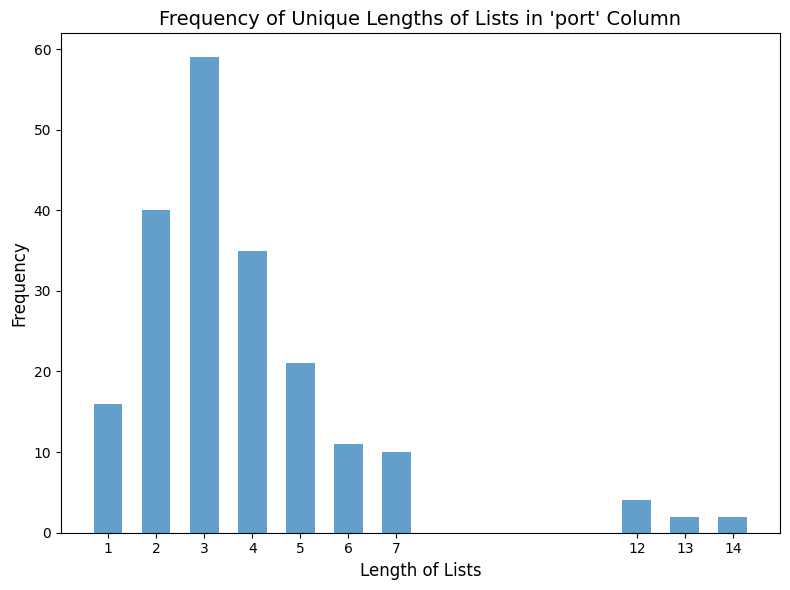

In [26]:
df_copy = df.copy()

# Calculate the lengths of the lists in the 'port' column
df_copy['port_length'] = df['port'].apply(len)

# Count the frequency of unique lengths
length_counts = df_copy['port_length'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(length_counts.index, length_counts.values, width=0.6, alpha=0.7)
plt.xlabel("Length of Lists", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Frequency of Unique Lengths of Lists in 'port' Column", fontsize=14)
plt.xticks(length_counts.index, fontsize=10)
plt.tight_layout()
plt.show()

Scenario 2: Unusual ports used

In [30]:
import generate_data_functions
reload(generate_data_functions)
from generate_data_functions import *

from importlib import reload
import grouped_iForest_functions
reload(grouped_iForest_functions)

all_exp = [] # List to store all experiments
# Lists to store metrics for each method
metrics_custom = {'precision': [], 'recall': [], 'f2': []}
metrics_reg = {'precision': [], 'recall': [], 'f2': []}
metrics_pairs = {'precision': [], 'recall': [], 'f2': []}
metrics_sum = {'precision': [], 'recall': [], 'f2': []}

# Loop over seeds
for seed in seeds:
    # Set the random seed for reproducibility
    np.random.seed(seed)
    
    # region generate the data
    df = generate_scan_data_2(
        DataParameters.num_ips,
        DataParameters.num_scans_per_ip,
        DataParameters.norm_list_length_distribution,
        norm_service_distribution,
        norm_port_distributions,
        DataParameters.anom_list_length_distribution,
        DataParameters.anom_service_distribution,
        DataParameters.anom_port_distribution,
        DataParameters.anomaly_rate,
        seed
    )
    def validate_ip_consistency(df):
        ip_mapping = df[['ipv4', 'ip_id']].drop_duplicates()
        assert len(ip_mapping) == len(ip_mapping['ipv4'].unique()), "Inconsistent ip_id assignments detected!"
    validate_ip_consistency(df)

    S = set(df[df['anomaly'] == 1]['ip_id'].unique())
    df_filtered = df[df['ip_id'].isin(S) & df['anomaly'] == 1]
    #print(df_filtered.drop(columns = ['ip_id']))

    # Add some hand written anomalies to the data
    '''anomalous_scans = [
    ['198.51.100.1', 0, 0, [80, 22, 21], ['HTTP', 'SSH', 'FTP'], 0],
    ['198.51.100.1', 0, 1, [143, 3306], ['IMAP', 'MYSQL'], 0],
    ['198.51.100.1', 0, 2, [80, 143], ['HTTP', 'IMAP'], 0],
    ['198.51.100.1', 0, 3, [22, 110], ['SSH', 'POP3'], 0],
    ['198.51.100.1', 0, 4, [53, 3306], ['DNS', 'MYSQL'], 0],
    ['198.51.100.1', 0, 5, [80, 3306], ['HTTP', 'MYSQL'], 1], # Anomaly: MYSQL on port 80
    ['198.51.100.1', 0, 6, [21, 143], ['FTP', 'IMAP'], 1],  # Anomaly: IMAP on port 21
    ['198.51.100.1', 0, 7, [22, 53], ['SSH', 'DNS'], 0],
    ['198.51.100.1', 0, 8, [110, 3306], ['POP3', 'MYSQL'], 0],
    ['198.51.100.1', 0, 9, [21, 143], ['FTP', 'IMAP'], 0]
]
    
    anomalous_df = pd.DataFrame(anomalous_scans, columns=['ipv4', 'ip_id', 'scan_id', 'port', 'service', 'anomaly'])

    df = pd.concat([df, anomalous_df], ignore_index=True)'''
    anomalous_rows = df[df['anomaly'] == 1]
    anomalous_ips = anomalous_rows['ip_id'].unique().tolist()
    print("Unique Anomalous IPs:", anomalous_ips)
    # endregion 

    # region compute anomalies
    custForest_flat_scores = cust_iforest_anomaly(df)

    reg_anomaly_dict = flattened(df)

    pairs_anomaly_dict = pairs_anomaly(df)

    sum_anomaly_dict = summarization(df)
    
    # Anomalous IPs from the Custom Isolation Forest (Flattening)
    custForest_anomalous_ips = [(int(ip), score) for ip, score in custForest_flat_scores.items() if score < 0]
     # Anomalous IPs from the Standard Isolation Forest (Flattening)
    regForest_anomalous_ips = [(int(ip), score) for ip, score in reg_anomaly_dict.items() if score < 0]
    # Standard Isolation Forest (IP-Port Pairs): (IP, score) pairs for anomalous IPs
    pairs_anomalous_ips = [(int(ip), score) for ip, score in pairs_anomaly_dict.items() if score < 0]
    # Standard Isolation Forest (Summarization): (IP, score) pairs for anomalous IPs
    sum_anomalous_ips = [(int(ip), score) for ip, score in sum_anomaly_dict.items() if score < 0]
    # endregion

    # region F2 scores
    # Calculate metrics for each method
    custom_prec, custom_rec, custom_f2 = calculate_metrics(anomalous_ips, custForest_anomalous_ips)
    reg_prec, reg_rec, reg_f2 = calculate_metrics(anomalous_ips, regForest_anomalous_ips)
    pairs_prec, pairs_rec, pairs_f2 = calculate_metrics(anomalous_ips, pairs_anomalous_ips)
    sum_prec, sum_rec, sum_f2 = calculate_metrics(anomalous_ips, sum_anomalous_ips)
    
    # Store metrics
    metrics_custom['precision'].append(custom_prec)
    metrics_custom['recall'].append(custom_rec)
    metrics_custom['f2'].append(custom_f2)

    metrics_reg['precision'].append(reg_prec)
    metrics_reg['recall'].append(reg_rec)
    metrics_reg['f2'].append(reg_f2)
    
    metrics_pairs['precision'].append(pairs_prec)
    metrics_pairs['recall'].append(pairs_rec)
    metrics_pairs['f2'].append(pairs_f2)
    
    metrics_sum['precision'].append(sum_prec)
    metrics_sum['recall'].append(sum_rec)
    metrics_sum['f2'].append(sum_f2)    
    # endregion

    # Store all information in the experiment dictionary
    exp = {
        'seed': seed,
        #'num_ips': num_ips,
        #'num_scans_per_ip': num_scans_per_ip,
        "Custom iForest Flattening scores": custForest_flat_scores,
        "iForest Pairs scores": pairs_anomaly_dict,
        "iForest Summarization scores": sum_anomaly_dict,
        "Actual Anomalous IPs": anomalous_ips,
        "Custom iForest Anomalous IPs": custForest_anomalous_ips,
        "iForest Pairs Anomalous IPs": pairs_anomalous_ips,
        "iForest Summarization Anomalous IPs": sum_anomalous_ips,
        "Custom iForest F2-Score": custom_f2,
        "iForest Pairs F2-Score": custom_f2,
        "iForest Summarization F2-Score": custom_f2
    }
    
    # Add the experiment dictionary to the list of all experiments
    all_exp.append(exp)

#region Print all experiments for verification
'''
for experiment in all_exp:
    for key, value in experiment.items():
        print(f"{key}: {value}")
    print("-" * 20)  # Separator between experiments
    '''
#endregion

# Calculate averages
avg_metrics = {
    'Custom iForest': {
        'Precision': mean(metrics_custom['precision']),
        'Recall': mean(metrics_custom['recall']),
        'F2-Score': mean(metrics_custom['f2'])
    },
    'iForest Pairs': {
        'Precision': mean(metrics_pairs['precision']),
        'Recall': mean(metrics_pairs['recall']),
        'F2-Score': mean(metrics_pairs['f2'])
    },
    'iForest Summarization': {
        'Precision': mean(metrics_sum['precision']),
        'Recall': mean(metrics_sum['recall']),
        'F2-Score': mean(metrics_sum['f2'])
    }
}

# Create and display results table
results_df = pd.DataFrame(avg_metrics).round(3)
print("\nAverage Performance Metrics:")
print("-" * 63)
print(results_df)
print("-" * 63)

Unique Anomalous IPs: [6, 9]
Unique Anomalous IPs: [1, 2]
Unique Anomalous IPs: [0, 1]
Unique Anomalous IPs: [3, 8]
Unique Anomalous IPs: [3, 4]

Average Performance Metrics:
---------------------------------------------------------------
           Custom iForest  iForest Pairs  iForest Summarization
Precision           0.360          0.250                  0.800
Recall              0.900          0.500                  0.400
F2-Score            0.692          0.417                  0.444
---------------------------------------------------------------


Scenario 3: Swap scenario

In [13]:

reload(generate_data_functions)

all_exp = [] # List to store all experiments
# Lists to store metrics for each method
metrics_custom = {'precision': [], 'recall': [], 'f2': []}
metrics_reg = {'precision': [], 'recall': [], 'f2': []}
metrics_pairs = {'precision': [], 'recall': [], 'f2': []}
metrics_sum = {'precision': [], 'recall': [], 'f2': []}

num_repetitions = 5 # todo move to calling function
seeds = range(num_repetitions)
num_ips=5
num_scans_per_ip=20
anomaly_rate=0.2
anomalous_scan_prob = 0.1
# Loop over seeds
for seed in seeds:
    # Set the random seed for reproducibility
    np.random.seed(seed)
    
    # region generate the data
    df = generate_scan_data_3(num_ips, num_scans_per_ip, typical_service_port_map, anomaly_rate, anomalous_scan_prob, seed)
    #print("Anomolous scans;;")
    #print(df[df['anomaly']==1])
    S = set(df[df['anomaly'] == 1]['ip_id'].unique())
    df_filtered = df[df['ip_id'].isin(S) & df['anomaly'] == 1]
    #print(df_filtered.drop(columns = ['ip_id']))

    # Add some hand written anomalies to the data
    '''anomalous_scans = [
    ['198.51.100.1', 0, 0, [80, 22, 21], ['HTTP', 'SSH', 'FTP'], 0],
    ['198.51.100.1', 0, 1, [143, 3306], ['IMAP', 'MYSQL'], 0],
    ['198.51.100.1', 0, 2, [80, 143], ['HTTP', 'IMAP'], 0],
    ['198.51.100.1', 0, 3, [22, 110], ['SSH', 'POP3'], 0],
    ['198.51.100.1', 0, 4, [53, 3306], ['DNS', 'MYSQL'], 0],
    ['198.51.100.1', 0, 5, [80, 3306], ['HTTP', 'MYSQL'], 1], # Anomaly: MYSQL on port 80
    ['198.51.100.1', 0, 6, [21, 143], ['FTP', 'IMAP'], 1],  # Anomaly: IMAP on port 21
    ['198.51.100.1', 0, 7, [22, 53], ['SSH', 'DNS'], 0],
    ['198.51.100.1', 0, 8, [110, 3306], ['POP3', 'MYSQL'], 0],
    ['198.51.100.1', 0, 9, [21, 143], ['FTP', 'IMAP'], 0]
]
    
    anomalous_df = pd.DataFrame(anomalous_scans, columns=['ipv4', 'ip_id', 'scan_id', 'port', 'service', 'anomaly'])

    df = pd.concat([df, anomalous_df], ignore_index=True)'''
    
    anomalous_ips = df[df['anomaly'] == 1]['ip_id'].unique()
    print('anomalous_ips:', anomalous_ips)
    # endregion 

    # region compute anomalies
    custForest_flat_scores = cust_iforest_anomaly(df)

    reg_anomaly_dict = flattened(df)

    pairs_anomaly_dict = pairs_anomaly(df)

    sum_anomaly_dict = summarization(df)
    
    # Anomalous IPs from the Custom Isolation Forest (Flattening)
    custForest_anomalous_ips = [(ip, score) for ip, score in custForest_flat_scores.items() if score < 0]
     # Anomalous IPs from the Standard Isolation Forest (Flattening)
    regForest_anomalous_ips = [(ip, score) for ip, score in reg_anomaly_dict.items() if score < 0]
    # Standard Isolation Forest (IP-Port Pairs): (IP, score) pairs for anomalous IPs
    pairs_anomalous_ips = [(ip, score) for ip, score in pairs_anomaly_dict.items() if score < 0]
    # Standard Isolation Forest (Summarization): (IP, score) pairs for anomalous IPs
    sum_anomalous_ips = [(ip, score) for ip, score in sum_anomaly_dict.items() if score < 0]
    # endregion

    # region F2 scores
    # Calculate metrics for each method
    custom_prec, custom_rec, custom_f2 = calculate_metrics(anomalous_ips, custForest_anomalous_ips)
    reg_prec, reg_rec, reg_f2 = calculate_metrics(anomalous_ips, regForest_anomalous_ips)
    pairs_prec, pairs_rec, pairs_f2 = calculate_metrics(anomalous_ips, pairs_anomalous_ips)
    sum_prec, sum_rec, sum_f2 = calculate_metrics(anomalous_ips, sum_anomalous_ips)
    
    # Store metrics
    metrics_custom['precision'].append(custom_prec)
    metrics_custom['recall'].append(custom_rec)
    metrics_custom['f2'].append(custom_f2)

    metrics_reg['precision'].append(reg_prec)
    metrics_reg['recall'].append(reg_rec)
    metrics_reg['f2'].append(reg_f2)
    
    metrics_pairs['precision'].append(pairs_prec)
    metrics_pairs['recall'].append(pairs_rec)
    metrics_pairs['f2'].append(pairs_f2)
    
    metrics_sum['precision'].append(sum_prec)
    metrics_sum['recall'].append(sum_rec)
    metrics_sum['f2'].append(sum_f2)    
    # endregion

    # Store all information in the experiment dictionary
    exp = {
        'seed': seed,
        'num_ips': num_ips,
        'num_scans_per_ip': num_scans_per_ip,
        "Custom iForest Flattening scores": custForest_flat_scores,
        "iForest Pairs scores": pairs_anomaly_dict,
        "iForest Summarization scores": sum_anomaly_dict,
        "Actual Anomalous IPs": anomalous_ips,
        "Custom iForest Anomalous IPs": custForest_anomalous_ips,
        "iForest Pairs Anomalous IPs": pairs_anomalous_ips,
        "iForest Summarization Anomalous IPs": sum_anomalous_ips,
        "Custom iForest F2-Score": custom_f2,
        "iForest Pairs F2-Score": custom_f2,
        "iForest Summarization F2-Score": custom_f2
    }
    
    # Add the experiment dictionary to the list of all experiments
    all_exp.append(exp)

#region Print all experiments for verification
'''
for experiment in all_exp:
    for key, value in experiment.items():
        print(f"{key}: {value}")
    print("-" * 20)  # Separator between experiments
    '''
#endregion

# Calculate averages
avg_metrics = {
    'Custom iForest': {
        'Precision': mean(metrics_custom['precision']),
        'Recall': mean(metrics_custom['recall']),
        'F2-Score': mean(metrics_custom['f2'])
    },
    'iForest Pairs': {
        'Precision': mean(metrics_pairs['precision']),
        'Recall': mean(metrics_pairs['recall']),
        'F2-Score': mean(metrics_pairs['f2'])
    },
    'iForest Summarization': {
        'Precision': mean(metrics_sum['precision']),
        'Recall': mean(metrics_sum['recall']),
        'F2-Score': mean(metrics_sum['f2'])
    }
}

# Create and display results table
results_df = pd.DataFrame(avg_metrics).round(3)
print("\nAverage Performance Metrics:")
print("-" * 63)
print(results_df)
print("-" * 63)

anomalous_ips: [3]
anomalous_ips: [1]
anomalous_ips: [0]
anomalous_ips: [1]
anomalous_ips: [1]

Average Performance Metrics:
---------------------------------------------------------------
           Custom iForest  iForest Pairs  iForest Summarization
Precision           0.600          0.100                    0.0
Recall              0.800          0.200                    0.0
F2-Score            0.733          0.167                    0.0
---------------------------------------------------------------


In [8]:
print(df[df['anomaly']==1])

           ipv4  ip_id  scan_id              port                 service  \
38  79.46.34.10      1       38  [21, 25, 80, 53]  [FTP, SMTP, DNS, HTTP]   
39  79.46.34.10      1       39  [53, 25, 21, 80]  [FTP, SMTP, DNS, HTTP]   

    anomaly  
38        1  
39        1  


In [9]:
df_pairs.head()

NameError: name 'df_pairs' is not defined

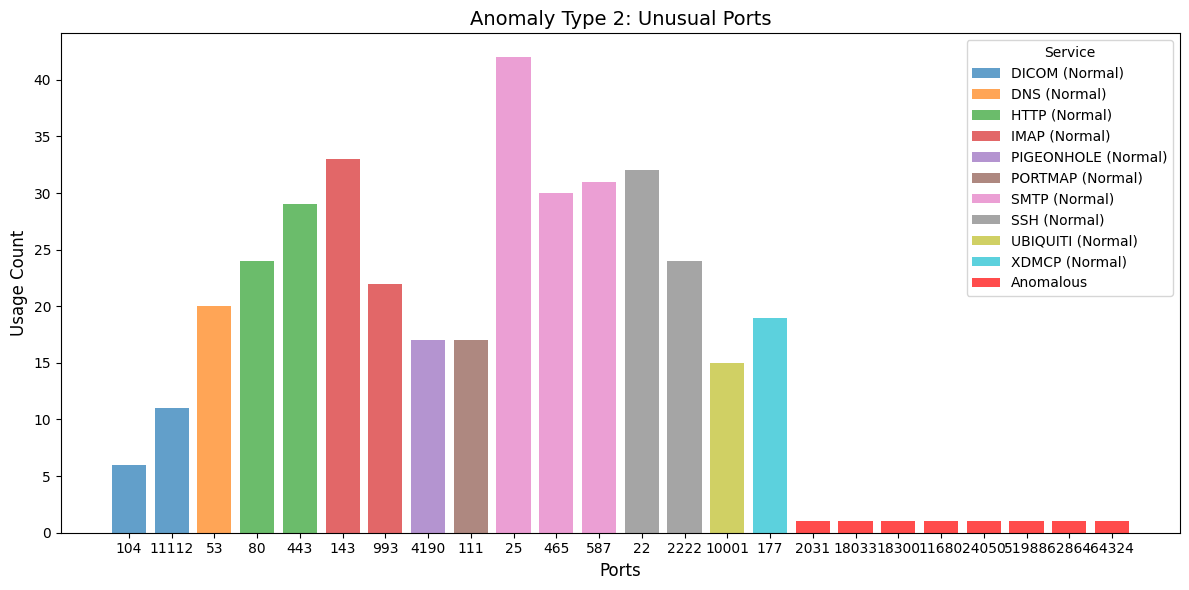

In [ ]:
flat_data = []
for _, row in df_pairs.iterrows():
    ports = row['port']
    services = row['service']
    for port, service in zip(ports, services):
        flat_data.append({
            'IP': row['ipv4'],
            'Scan ID': row['scan_id'],
            'Port': port,
            'Service': service,
            'Anomaly': row['anomaly']
        })

df_flat = pd.DataFrame(flat_data)

# Aggregate data for plotting
plot_data = df_flat.groupby(['Service', 'Port', 'Anomaly']).size().reset_index(name='Usage Count')

# Plot
plt.figure(figsize=(12, 6))
for service in plot_data['Service'].unique():
    service_data = plot_data[(plot_data['Service'] == service) & (plot_data['Anomaly'] == 0)]
    plt.bar(
        service_data['Port'].astype(str), 
        service_data['Usage Count'], 
        label=f"{service} (Normal)", 
        alpha=0.7
    )

# Highlight anomalous ports in red
anomalous_data = plot_data[plot_data['Anomaly'] == 1]
if not anomalous_data.empty:
    plt.bar(
        anomalous_data['Port'].astype(str), 
        anomalous_data['Usage Count'], 
        color='red', 
        label='Anomalous', 
        alpha=0.7
    )

plt.title('Anomaly Type 2: Unusual Ports', fontsize=14)
plt.xlabel('Ports', fontsize=12)
plt.ylabel('Usage Count', fontsize=12)
plt.legend(title='Service', loc='upper right')
plt.tight_layout()
plt.show()

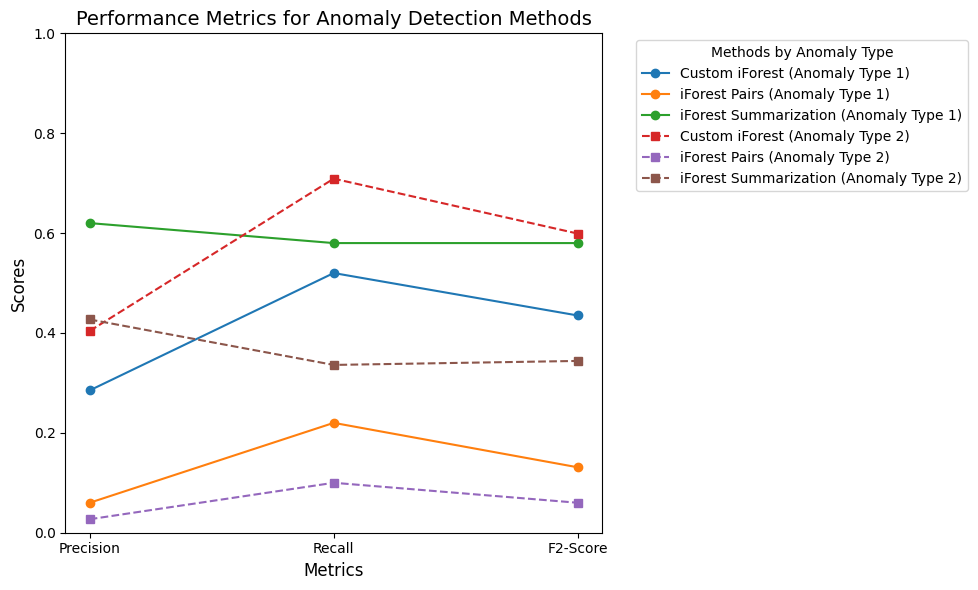

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
methods = ['Custom iForest', 'iForest Pairs', 'iForest Summarization']
metrics = ['Precision', 'Recall', 'F2-Score']

# Reshape data for plotting
anomaly_1_scores = np.array([
    [0.285, 0.520, 0.435],  # Custom iForest
    [0.060, 0.220, 0.131],  # iForest Pairs
    [0.62, 0.58, 0.58]      # iForest Summarization
])

anomaly_2_scores = np.array([
    [0.404, 0.709, 0.599],  # Custom iForest
    [0.027, 0.100, 0.060],  # iForest Pairs
    [0.427, 0.336, 0.344]   # iForest Summarization
])

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot lines for Anomaly Type 1
for i, method in enumerate(methods):
    plt.plot(metrics, anomaly_1_scores[i], marker='o', label=f"{method} (Anomaly Type 1)")

# Plot lines for Anomaly Type 2
for i, method in enumerate(methods):
    plt.plot(metrics, anomaly_2_scores[i], marker='s', linestyle='--', label=f"{method} (Anomaly Type 2)")

# Add labels, title, and legend
plt.title("Performance Metrics for Anomaly Detection Methods", fontsize=14)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Scores", fontsize=12)
plt.ylim(0, 1)  # Set consistent scale for scores
plt.legend(title="Methods by Anomaly Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()


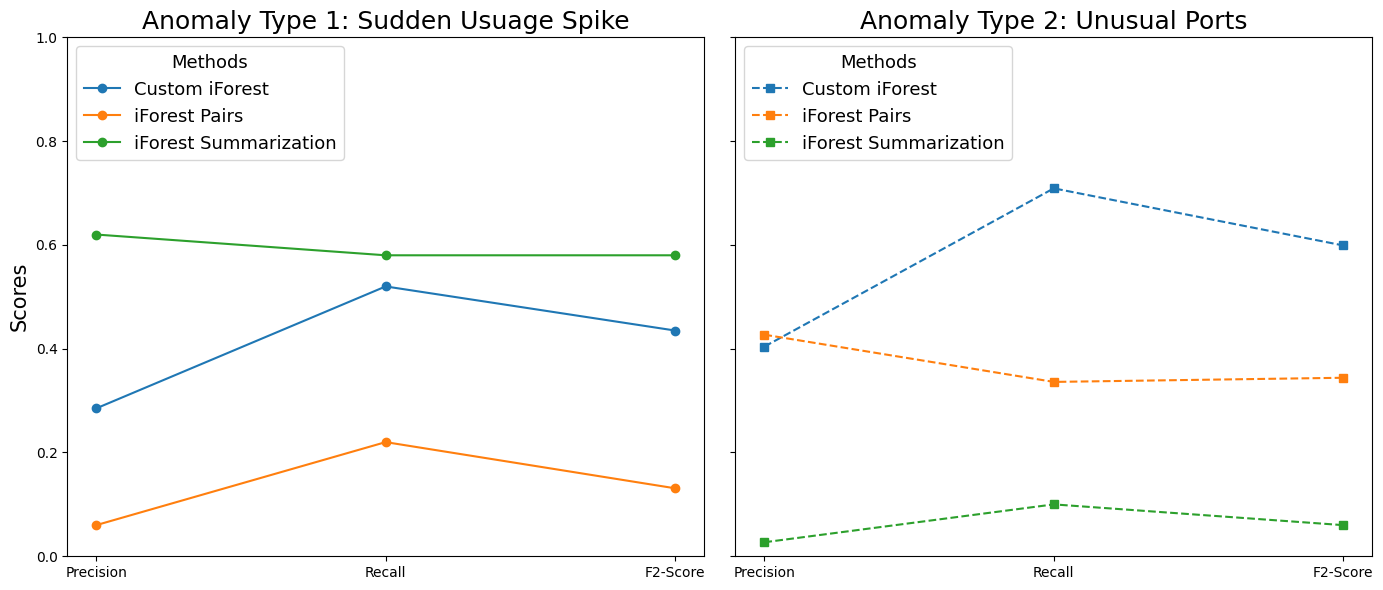

In [112]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
methods = ['Custom iForest', 'iForest Pairs', 'iForest Summarization']
metrics = ['Precision', 'Recall', 'F2-Score']

# Reshape data for plotting
anomaly_1_scores = np.array([
    [0.285, 0.520, 0.435],  # Custom iForest
    [0.060, 0.220, 0.131],  # iForest Pairs
    [0.62, 0.58, 0.58]      # iForest Summarization
])

anomaly_2_scores = np.array([
    [0.404, 0.709, 0.599],  # Custom iForest
    [0.427, 0.336, 0.344],
    [0.027, 0.100, 0.060]   # iForest Summarization
])

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for Anomaly Type 1
for i, method in enumerate(methods):
    axs[0].plot(metrics, anomaly_1_scores[i], marker='o', label=method)
axs[0].set_title("Anomaly Type 1: Sudden Usuage Spike", fontsize=18)
axs[0].set_ylabel("Scores", fontsize=15)
axs[0].set_ylim(0, 1)  # Set consistent scale for scores
legend = axs[0].legend(title="Methods", loc='upper left', fontsize=13)
legend.set_title("Methods", prop={'size': 13})

# Plot for Anomaly Type 2
for i, method in enumerate(methods):
    axs[1].plot(metrics, anomaly_2_scores[i], marker='s', linestyle='--', label=method)
axs[1].set_title("Anomaly Type 2: Unusual Ports", fontsize=18)
axs[0].set_ylabel("Scores", fontsize=15)
axs[1].set_ylim(0, 1)  # Set consistent scale for scores
legend = axs[1].legend(title="Methods", loc='upper left', fontsize=13)
legend.set_title("Methods", prop={'size': 13})
# Adjust layout
plt.tight_layout()
plt.savefig("scores.pdf")


In [47]:
df.columns

Index(['ipv4', 'ip_id', 'scan_id', 'port', 'service', 'anomaly'], dtype='object')

In [48]:
unique_ports = df['port'].explode().unique()
unique_services = df['service'].explode().unique()

print(f"Number of unique ports: {len(unique_ports)}")
print(f"Number of unique services: {len(unique_services)}")

Number of unique ports: 141
Number of unique services: 46


In [57]:
import pandas as pd

# Assuming your DataFrame is called 'df'
port_lengths = df['port'].explode().value_counts()

sum = 0
print("Port Instance Counts:")
for port, count in port_lengths.items():
    sum += count

print(sum)

Port Instance Counts:
756


In [51]:
import pandas as pd

# Assuming your DataFrame is called 'df'
port_lengths = df['port'].apply(len)
service_lengths = df['service'].apply(len)

print("Port List Length Counts:")
print(port_lengths.value_counts())
print("\nService List Length Counts:")
print(service_lengths.value_counts())

Port List Length Counts:
port
3     59
2     40
4     35
5     21
1     16
6     11
7     10
12     4
14     2
13     2
Name: count, dtype: int64

Service List Length Counts:
service
3     59
2     40
4     35
5     21
1     16
6     11
7     10
12     4
14     2
13     2
Name: count, dtype: int64


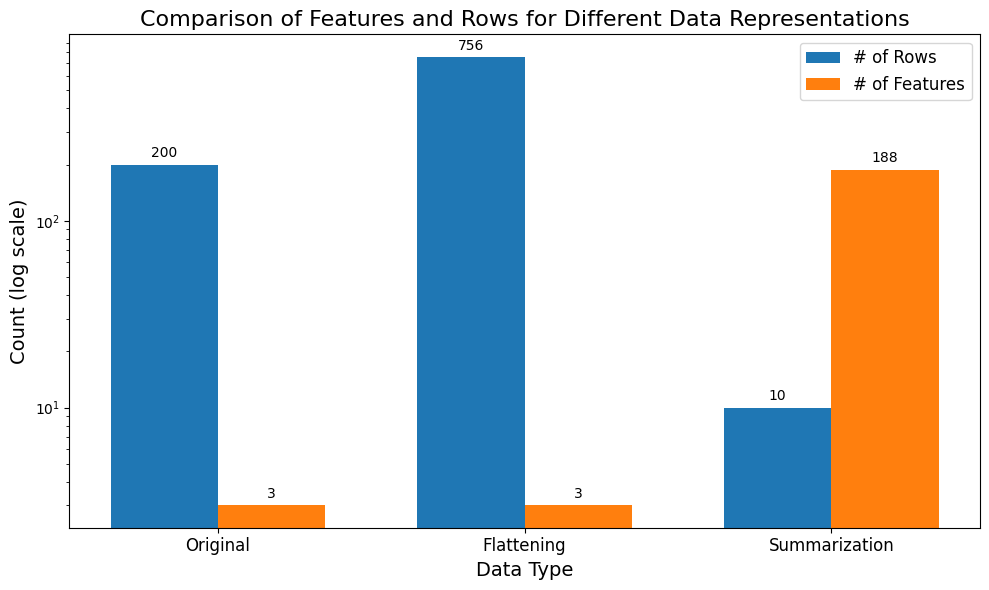

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df, pairs, and summarize_features are already defined

n_df = df[['ipv4', 'port', 'service']].copy()
# Prepare data
original_features = len(n_df.columns)
original_rows = len(n_df)

pairs_df = pairs(df)
pairs_features = len(pairs_df.columns)
pairs_rows = 756

summarized_df = summarize_features(df)
summarized_features = 188
summarized_rows = len(summarized_df)

# Data for plotting
categories = ['Original', 'Flattening', 'Summarization']
features = [original_features, pairs_features, summarized_features]
rows = [original_rows, pairs_rows, summarized_rows]

# Plot
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Switch bar positions: # of Rows on the left, # of Features on the right
rects1 = ax.bar(x - width/2, rows, width, label='# of Rows')
rects2 = ax.bar(x + width/2, features, width, label='# of Features')

# Add labels, title, and custom x-axis tick labels, etc., with specified font sizes
ax.set_xlabel('Data Type', fontsize=14)
ax.set_ylabel('Count (log scale)', fontsize=14)
ax.set_title('Comparison of Features and Rows for Different Data Representations', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=12)
ax.set_yscale('log')  # Log scale for y-axis
ax.legend(fontsize=12, title_fontsize=12)

# Add values on top of the bars
def add_bar_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_bar_labels(rects1)
add_bar_labels(rects2)

fig.tight_layout()
plt.show()

